# PROCESO ETL 
Proceso ETL con datos de migración de extranjeros en Colombia, que podría servir a las entidades del estado para crear estrategias y tomar decisiones oportunas.

### importar las librerias que se van a utilizar

In [115]:
import pandas as pd
from arcgis.gis import GIS
from pathlib import Path
from zipfile import ZipFile
from arcgis.features import FeatureLayer
from arcgis.features import FeatureSet
import numpy as np
from arcgis.features import SpatialDataFrame
import os
import warnings
from arcgis.features import use_proximity
import zipfile

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10

### Los datos fueron tomados del repositorio de datos abiertos

https://www.datos.gov.co/Estad-sticas-Nacionales/Entradas-de-extranjeros-a-Colombia/96sh-4v8d

Se descargaron los archivos csv y se ubicaron en la misma carpeta del proyecto.

Posteriormente se convierten los datos a un DataFrame de pandas.



In [116]:
df = pd.read_csv("Entradas_de_extranjeros_a_Colombia.csv",dtype={'Nueva columna georreferenciada':'str'})
df=df.dropna(axis=0, subset=['Nueva columna georreferenciada'])
df=df[df['Nacionalidad'] == 'Venezuela']
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356)
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794)
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486)
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479)
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675)
...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317)
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013)
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188)
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396)


### Aplicación de funciones lambda
Con el fin de Limpiar las coordenadas, quitando la palabra ‘POINT’ 

In [117]:
def limpiarCoord(df):
    lonlat=(df
               .apply(lambda row: row['Nueva columna georreferenciada'],axis=1)
               .apply(lambda word: word.replace('POINT (',''))
               .apply(lambda body: list(body))
               .apply(lambda letters: list(map(lambda letter:letter.replace(")",''),letters)))
               .apply(lambda letters: ''.join(letters))
                  )            
    df['lat long']=lonlat
    latlon_df = df['lat long'].apply(lambda x: pd.Series(x.split(' ')))
    df['latt']=latlon_df[0]
    df['lonn']=latlon_df[1]
    df=df.dropna(axis=0, subset=['latt'])
    df=df.dropna(axis=0, subset=['lonn'])
    return df

In [118]:
df=limpiarCoord(df)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada,lat long,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356),0.81488 -77356,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794),10406342 -75527794,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486),10446304 -75516486,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479),10886686 -74776479,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675),11117206 -74232675,11117206,-74232675
...,...,...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317),7128047 -73181317,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013),7819 -72453013,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188),7927233 -72508188,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396),836068 -72409396,836068,-72409396


## Ubicar el punto

In [119]:
def corrLonLat(df):
    long=df['lonn']
    df['long']=0
    for i in range(len(df)):
         df['long'].iloc[i]=(long.iloc[i])[0:3]+'.'+(long.iloc[i])[3:]
    lat=df['latt']
    df['lat']=0
    for i in range(len(df)):
        if (lat.iloc[i])[0]=='1':
            df['lat'].iloc[i]=(lat.iloc[i])[0:2]+'.'+(lat.iloc[i])[2:]
        elif (lat.iloc[i])[0]=='-':
            df['lat'].iloc[i]=(lat.iloc[i])[1:2]+'.'+(lat.iloc[i])[2:]
        elif (lat.iloc[i])[0]=='0':
            df['lat'].iloc[i]=(lat.iloc[i])[0:1]+'.'+(lat.iloc[i])[2:]
        else:
            df['lat'].iloc[i]=(lat.iloc[i])[0:1]+'.'+(lat.iloc[i])[1:]   
    df[['long','lat']] = df[['long','lat']].apply(pd.to_numeric)
    df=df.drop(columns=['latt', 'lonn','lat long', 'Nueva columna georreferenciada'], axis=1)
    return df

In [34]:
df=corrLonLat(df)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada,lat long,latt,lonn,long,lat
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356),0.81488 -77356,0.81488,-77356,-77.356000,0.814880
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794),10406342 -75527794,10406342,-75527794,-75.527794,10.406342
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486),10446304 -75516486,10446304,-75516486,-75.516486,10.446304
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479),10886686 -74776479,10886686,-74776479,-74.776479,10.886686
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675),11117206 -74232675,11117206,-74232675,-74.232675,11.117206
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317),7128047 -73181317,7128047,-73181317,-73.181317,7.128047
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013),7819 -72453013,7819,-72453013,-72.453013,7.819000
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188),7927233 -72508188,7927233,-72508188,-72.508188,7.927233
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396),836068 -72409396,836068,-72409396,-72.409396,8.360680


In [120]:
df=pd.read_csv('MigracionFinal.csv')
df

,Unnamed: 0,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,long,lat
0,907,2012,Enero,Venezuela,297,339,NaN,636,-77.356000,0.814880
1,908,2012,Enero,Venezuela,7,12,NaN,19,-75.527794,10.406342
2,909,2012,Enero,Venezuela,76,133,NaN,209,-75.516486,10.446304
3,910,2012,Enero,Venezuela,55,70,NaN,125,-74.776479,10.886686
4,911,2012,Enero,Venezuela,0,4,NaN,4,-74.232675,11.117206
...,...,...,...,...,...,...,...,...,...,...
1729,67653,2019,Junio,Venezuela,9,13,NaN,22,-73.181317,7.128047
1730,67654,2019,Junio,Venezuela,29976,26826,NaN,56802,-72.453013,7.819000
1731,67655,2019,Junio,Venezuela,12,28,NaN,40,-72.508188,7.927233
1732,67656,2019,Junio,Venezuela,1904,1597,NaN,3501,-72.409396,8.360680


## CSV

In [11]:
df.to_csv('MigracionFinal.csv', sep=',', encoding='utf-8')

## Conexión con ArcGis online
por medio de la cuenta de ArcGis Online establecer la conexión 

In [29]:
gis = GIS("https://www.arcgis.com", username="rcmartinb")

Enter password: ········


### Publicación del archivo csv

In [114]:
Migvenezuela_properties = {
    'title': 'Migración Venezuela',
    'tags': ['migracion1','migracion2'],
    'type': 'CSV'
}
Migvenezuela_file_location = 'MigracionFinal.csv'
Migvenezuela_csv = gis.content.add(Migvenezuela_properties, data=Migvenezuela_file_location,folder="API Python demos")
#Se publica para volverlo un dato geográfico
Migvenezuela_feature_layer = Migvenezuela_csv.publish()
Migvenezuela_feature_layer

<Item title:"Migración Venezuela" type:Feature Layer Collection owner:rcmartinb>

## Visualización del mapa

In [121]:
m = gis.map()
m.center = [4, -74]           # `[latitude, longitude]`
m.zoom = 5
m.add_layer(Migvenezuela_feature_layer)
m

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

## Buffer respecto al total

### Spatial enabled dataframe

In [122]:
query = 'title: "Migración Venezuela" AND type: "Feature Service"'
search_results = gis.content.search(query=query, max_items=10)
Capa = search_results[0]
feature_layers = Capa.layers
MigVen_layer = feature_layers[0]
MigVen_layer.properties.name

'Migración_Venezuela'

In [123]:
sdf = pd.DataFrame.spatial.from_layer(MigVen_layer)
sdf

,Año,Femenino,Indefinido,Masculino,Mes,Nacionalidad,ObjectId,SHAPE,Total,lat,long
0,2012,297,None,339,Enero,Venezuela,1,"{""x"": -8611230.529804472, ""y"": 90715.084940370...",636,0.814880,-77.356000
1,2012,7,None,12,Enero,Venezuela,2,"{""x"": -8407715.568819262, ""y"": 1164850.6920302...",19,10.406342,-75.527794
2,2012,76,None,133,Enero,Venezuela,3,"{""x"": -8406456.768017374, ""y"": 1169373.9273230...",209,10.446304,-75.516486
3,2012,55,None,70,Enero,Venezuela,4,"{""x"": -8324079.565593916, ""y"": 1219259.1126269...",125,10.886686,-74.776479
4,2012,0,None,4,Enero,Venezuela,5,"{""x"": -8263543.58122257, ""y"": 1245400.96922767...",4,11.117206,-74.232675
...,...,...,...,...,...,...,...,...,...,...,...
1729,2019,18,None,40,Febrero,Venezuela,1730,"{""x"": -8071574.566502949, ""y"": 885284.48624014...",58,7.927233,-72.508188
1730,2019,1636,None,1283,Febrero,Venezuela,1731,"{""x"": -8060577.0913685, ""y"": 934027.2631330751...",2919,8.360680,-72.409396
1731,2019,2,None,2,Marzo,Venezuela,1732,"{""x"": -7785851.942678761, ""y"": 466974.65828511...",4,4.191162,-69.941498
1732,2019,4,None,4,Marzo,Venezuela,1733,"{""x"": -7785844.48427288, ""y"": 469532.980039683...",8,4.214082,-69.941431


## Filtrar 

In [124]:
sdf1=sdf[sdf['Año']==2018]
sdf1=sdf1[sdf1['Mes']=='Enero']
sdf1=sdf1.drop(columns=['Indefinido'], axis=1)
sdf1

,Año,Femenino,Masculino,Mes,Nacionalidad,ObjectId,SHAPE,Total,lat,long
1399,2018,5,3,Enero,Venezuela,1400,"{""x"": -7785851.942678761, ""y"": 466974.65828511...",8,4.191162,-69.941498
1400,2018,0,1,Enero,Venezuela,1401,"{""x"": -7785844.48427288, ""y"": 469532.980039683...",1,4.214082,-69.941431
1401,2018,24,24,Enero,Venezuela,1402,"{""x"": -8557846.822716594, ""y"": 36737.861493294...",48,0.330020,-76.876446
1402,2018,2200,2314,Enero,Venezuela,1403,"{""x"": -8611230.529804472, ""y"": 90715.084940370...",4514,0.814880,-77.356000
1403,2018,0,1,Enero,Venezuela,1404,"{""x"": -8772274.099425793, ""y"": 2037715.9244116...",1,18.001430,-78.802679
...,...,...,...,...,...,...,...,...,...,...
1437,2018,13,16,Enero,Venezuela,1438,"{""x"": -8146506.944021136, ""y"": 795545.36973172...",29,7.128047,-73.181317
1439,2018,33395,47879,Enero,Venezuela,1440,"{""x"": -8065432.513598431, ""y"": 873121.39069658...",81274,7.819000,-72.453013
1441,2018,5,15,Enero,Venezuela,1442,"{""x"": -8071574.566502949, ""y"": 885284.48624014...",20,7.927233,-72.508188
1443,2018,2086,2853,Enero,Venezuela,1444,"{""x"": -8060577.0913685, ""y"": 934027.2631330751...",4939,8.360680,-72.409396


## Guardar shape

In [125]:
def CreateShapefile(df,name):
    os.mkdir("export/{}".format(name))
    df.spatial.to_featureclass(location=r"export/{}/{}.shp".format(name,name))
    shape_zip = zipfile.ZipFile('export/{}.zip'.format(name,name), 'w')
    for folder, subfolders, files in os.walk('export/{}/'.format(name)):
        for file in files:
            shape_zip.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), 'export/{}/'.format(name)), compress_type = zipfile.ZIP_DEFLATED)
    shape_zip.close()

In [126]:
name= "MigVenEnero2018"
CreateShapefile(sdf1,name)

## Publicar el shape

In [127]:
shape_properties = {
    'title': 'Migración Venezuela Enero 2018',
    'tags': 'Venezuela',
    'type': 'Shapefile'
}
shape_file_location = 'export/{}.zip'.format(name)
MigVEN201801_shp = gis.content.add(shape_properties, data=shape_file_location,folder="API Python demos")
MigVEN201801_item = MigVEN201801_shp.publish()
MigVEN201801_item

<Item title:"Migración Venezuela Enero 2018" type:Feature Layer Collection owner:rcmartinb>

### Seleccionamos el campo total para el buffer


In [131]:
buffer = use_proximity.create_buffers(MigVEN201801_item,
                                                     field='Total',
                                                     units='meters',
                                                     output_name='buffer_Migven201801')

In [132]:
m2 = gis.map()
m2.center = [4, -74]           # `[latitude, longitude]`
m2.zoom = 5
m2.add_layer(buffer)
m2

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

# Análisis Descriptivo
##### Con los datos limpios y publicados en ArcGis online, tambien podemos hacer es realizar un análisis descriptivo que permita entender parametros determinantes para la toma de decisiones

In [135]:
import matplotlib.pyplot as plt

Gráfica de cantidad agrupado por años

In [136]:
df3=df[['Año','Total']]
df3=df3.groupby(['Año'])['Total'].sum()
df3

Año
2012     251475
2013     261343
2014     245649
2015     273109
2016     323734
2017     698262
2018    1359816
2019     553191
Name: Total, dtype: int64

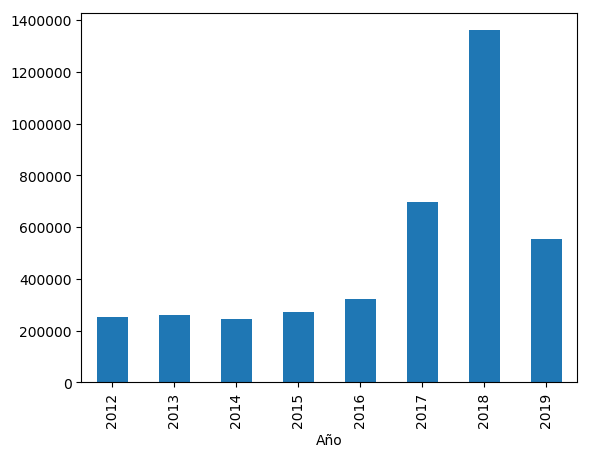

In [137]:
df3.plot(kind='bar')

Gráfica agrupado por género

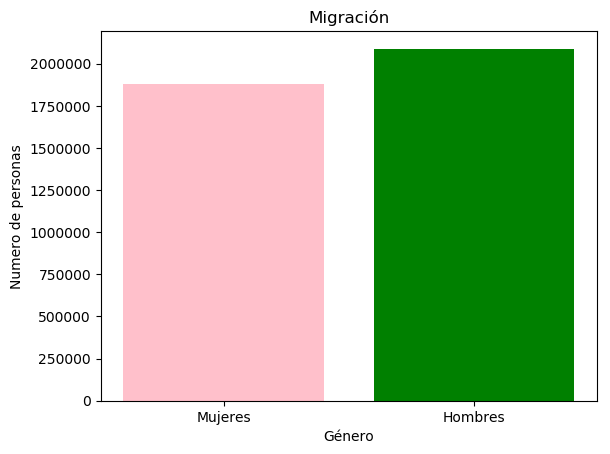

In [138]:
x = ["Mujeres","Hombres"]
y = [df['Femenino'].sum(),df['Masculino'].sum()]

plt.bar(x, y, color=['pink','green'])

plt.title('Migración')
plt.xlabel('Género')
plt.ylabel('Numero de personas')
#plt.savefig('ScatterPlot_03.png')
plt.show()

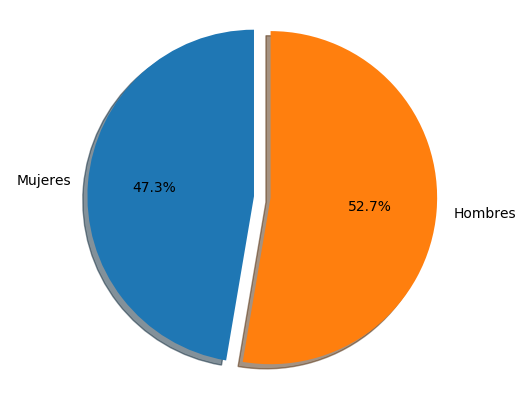

In [139]:
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Unificar gráficos

In [140]:
dfx=pd.DataFrame(columns=['Año','Femenino'])

dfy=df.groupby('Año').sum()
dfy= dfy.drop(columns=['Indefinido','long', 'lat'], axis=1)
dfy

,Unnamed: 0,Femenino,Masculino,Total
Año,,,,
2012,1515433,113984,137491,251475
2013,4186476,117070,144273,261343
2014,4753605,107787,137862,245649
2015,6218915,124369,148740,273109
2016,7947905,148830,174904,323734
2017,9303841,320487,377775,698262
2018,17435951,658110,701706,1359816
2019,10372738,286516,266675,553191


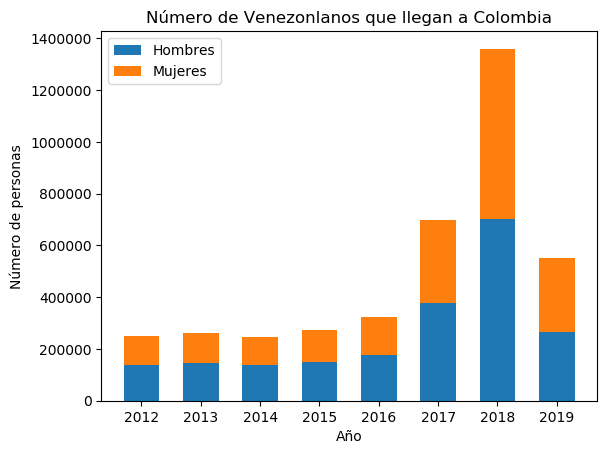

In [141]:
import numpy as np

N = 8
hombres = dfy['Masculino']
mujeres = dfy['Femenino']
hombStd = (2, 3, 4, 1, 2,2,2,2)
mujStd = (3, 5, 2, 3, 3,2,2,2)
ind = np.arange(N)   
width = 0.6       

p1 = plt.bar(ind, hombres, width, yerr=hombStd)
p2 = plt.bar(ind, mujeres, width,
             bottom=hombres, yerr=mujStd)

plt.ylabel('Número de personas')
plt.xlabel('Año')
plt.title('Número de Venezonlanos que llegan a Colombia')
plt.xticks(ind, (df3.index))

plt.legend((p1[0], p2[0]), ('Hombres', 'Mujeres'))

plt.show()

#### Agrupado por mes

In [142]:
df4=df[['Mes','Total']]
df4=df4.groupby(['Mes'])['Total'].sum()
df4

Mes
Abril         350704
Agosto        382701
Diciembre     357805
Enero         363209
Febrero       331027
               ...  
Marzo         316905
Mayo          342949
Noviembre     294935
Octubre       296616
Septiembre    296129
Name: Total, Length: 12, dtype: int64

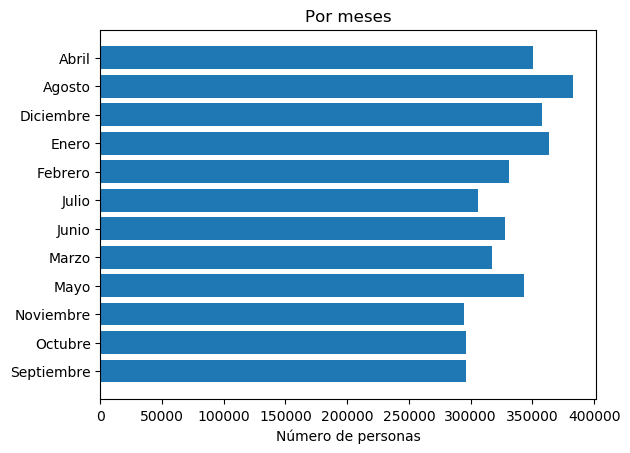

In [143]:
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

meses = df4.index
y_pos = np.arange(len(meses))
performance = df4

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(meses)
ax.invert_yaxis()
ax.set_xlabel('Número de personas')
ax.set_title('Por meses')

plt.show()

### Datos importantes
Como máximo, mínimo, mediana, entre otros datos estadísticos importantes

In [144]:
dfy.describe()

,Unnamed: 0,Femenino,Masculino,Total
count,8.000000e+00,8.000000,8.000000,8.000000e+00
mean,7.716858e+06,234644.125000,261178.250000,4.958224e+05
std,4.870206e+06,190256.584618,197103.160796,3.867902e+05
min,1.515433e+06,107787.000000,137491.000000,2.456490e+05
25%,4.611823e+06,116298.500000,142670.250000,2.588760e+05
50%,7.083410e+06,136599.500000,161822.000000,2.984215e+05
75%,9.571065e+06,295008.750000,294450.000000,5.894588e+05
max,1.743595e+07,658110.000000,701706.000000,1.359816e+06


In [134]:
print("Maximo: {}, Mínimo: {}, Promedio : {}".format(df["Total"].max(), df["Total"].min(), df["Total"].mean()))

Maximo: 82609, Mínimo: 1, Promedio : 2287.531141868512
